<a href="https://colab.research.google.com/github/Ryukijano/-Transformers-/blob/main/mask_former_hf_transformers_panoptic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#installing necessary libraries

!pip install datasets -qq
!pip install evaluate -qq
!pip install albumentations -qq
!pip install git+https://github.com/huggingface/transformers.git -qq

#for uploading model into hugging_face_hub
!pip install huggingface_hub -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 3

In [5]:
#importing libaries
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader

import albumentations as A 

import numpy as np 
import pandas as pd

from datasets import load_dataset
from transformers import (
    MaskFormerConfig,
    MaskFormerImageProcessor,
    MaskFormerModel,
    MaskFormerForInstanceSegmentation,
)

import evaluate
from huggingface_hub import notebook_login

In [6]:
'''
We are using the ADE20K dataset, consisting of over 20k images and their segmentation annotations. Named after Adela Burriuso, who single handedly annoted the dataset.
ADE20K is among the most popular and widely used semantic segmentation datasets. 
The Scene Parsing dataset has 150 semantic labels for the semantic segmentation task and 100 for the instance segmentation task.
'''
#loading the dataset using HF libraries

train = load_dataset("scene_parse_150", "instance_segmentation", split="train")
validation = load_dataset("scene_parse_150", "instance_segmentation", split="validation")
test = load_dataset("scene_parse_150", "instance_segmentation", split="test")



Generating train split:   0%|          | 0/20210 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset scene_parse_150 downloaded and prepared to /root/.cache/huggingface/datasets/scene_parse_150/instance_segmentation/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75. Subsequent calls will reuse this data.


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256 at 0x7FB2BAC9EF10>, 'annotation': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7FB2BAC9E250>}
[Info] Displaying a random image and its annotation...


(-0.5, 639.5, 479.5, -0.5)

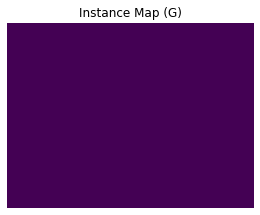

In [9]:
#exploring the dataset
print(train[0])
#grabbing a random index of the training dataset
print("[Info] Displaying a random image and its annotation...")
index = random.randint(0, len(train))

#using the random index grabbing the corresponding datapoint
#from the training datset
image = train[index]["image"]
image = np.array(image.convert("RGB"))
annotation = train[index]["annotation"]
annotation = np.array(annotation)

#plotting the original image and the annotations
plt.figure(figsize=(15,5))
for plot_index in range(3):
  if plot_index == 0:
    #if plot_index is 0, we display the original image
    plot_image = image
    title = "Original"
  else:
    #else plot the annotation maps
    plot_image = annotation[..., plot_index - 1]
    title = ["Class Map (R)","Instance Map (G)"][plot_index - 1]

#plotting the image
plt.subplot(1,3, plot_index + 1)
plt.imshow(plot_image)
plt.title(title)
plt.axis("off")

#Instance Segmentation Annotations

We look at instance segmentation annotations. As described in the Scene Parsing dataset page, [link text](https://huggingface.co/datasets/scene_parse_150) the instance annotation masks are stored in RGB image format and structured as follows:

The R(ed) channel encodes category ID.
The G(reen) channel encodes instance ID.
Instance IDs are assigned per image such that each object in an annotation image has a different instance ID (regardless of its class ID). In contrast, different annotation images can have objects with the same instance ID. Each image in the dataset has < 256 object instances.
We can refer to this file [link text](https://github.com/CSAILVision/placeschallenge/blob/master/instancesegmentation/instanceInfo100_train.txt) (train split) for the 100 class labels included in the instance segmentation subset of Scene Parsing.

Semantic and instance segmentation subsets of Scene Parsing don’t have the same id2label mapping. To find the mapping between the semantic categories for instance_segmentation and semantic_segmentation and the ADE20K dataset, we need to refer to Mapping.txt.



Preprocessing the Dataset
For any 🤗 Transformers vision model, we can simply use the corresponding FeatureExtractor or ImageProcessor class to preprocess raw images (and segmentation maps) and convert them to the format expected by the model.

As Scene Parsing is a large image dataset, we will call the preprocessor as we iterate over the training and validation loops instead of preprocessing all data at once.

FeatureExtractor and ImageProcessor Classes
Each model on the 🤗 Hub has a corresponding FeatureExtractor or ImageProcessor or Processor (for multi-modal models) class that is used to preprocess the raw image (or text, speech, etc.) such that it has the expected input shape and format used by the model. Some classes also include convenient post-processing methods to convert raw model outputs to final predictions.

Same as the Model and Config class, we can use the from_pretrained() method to retrieve the processor of any pre-trained model.



In [13]:
'''
from transformers import XXXModelImageProcessor

# Use default configuration
preprocessor = XXXModelImageProcessor.from_pretrained(<MODEL_NAME>)

train = load_dataset(<DATASET>)["train"]
for data in train:
    model = XXXModelImageProcessor(data[<target_key>])
'''

'\nfrom transformers import XXXModelImageProcessor\n\n# Use default configuration\npreprocessor = XXXModelImageProcessor.from_pretrained(<MODEL_NAME>)\n\ntrain = load_dataset(<DATASET>)["train"]\nfor data in train:\n    model = XXXModelImageProcessor(data[<target_key>])\n'

#Defining a Preprocessor Configuration

An important point to note here is that the preprocessor configuration needs to be consistent with the model configuration chosen for the input data to be preprocessed correctly (e.g., expected image size, normalization, augmentation, …).

As there are no model checkpoints available on the hub that were trained on the Scene Parsing dataset, we will create our custom preprocessor configuration.

In [14]:
#Creating the MaskFormer Image Preprocessor
processor = MaskFormerImageProcessor(
    reduce_labels=True,
    size=(512, 512),
    ignore_index=255,
    do_resize=False,
    do_rescale=False,
    do_normalize=False,
)


/usr/local/lib/python3.9/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:419: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(
